In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-10-31 01:57:42--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.224.224, 52.216.9.229, 16.182.33.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.224.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.8MB/s    in 0.7s    

2023-10-31 01:57:43 (18.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
#dataset 확인을 해보자!

import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
#데이터 전체를 넘파이 배열로 바꾸고, 온도로 하나 / 나머지로 하나 이렇게 만든다.

import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

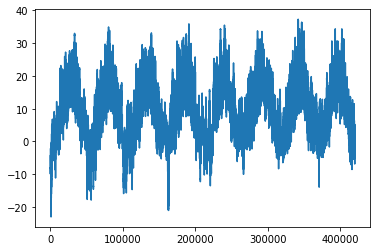

In [4]:
#온도를 그래프로 확인 

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

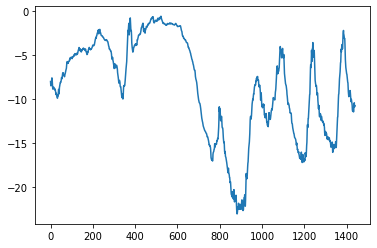

In [6]:
#처음 10일간의 온도 데이터, 10분으로 측청된 것이 기록되었으므로 1일에 1440의 데이터 포인트가 있다.

plt.plot(range(1440), temperature[:1440])
plt.show()

In [7]:
#데이터 분할

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [8]:
#데이터 정규화

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
#timeseries_dataset_from_array()이해하기

import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [10]:
#훈련/검증 데이터셋 만들기 -(samples, targets)튜플 반환

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [11]:
#train dataset 배치 크기 확인하기

for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


In [12]:
#상식수준의 기준점: 가장 기본이 되는 모델의 성능의 기준을 의미한다. (적어도 이 정도는 넘어라)
# 각 문제별, 상황별 상식수준의 기준점을 어떻게 잡아야하는지 파악할 수 있어야 한다.
# 여기서는 오늘 온도가 내일 온도로 예측한 경우로 테스트

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


In [13]:
# 상식수준 넘을까? 모델 1: 간단한 dense model

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 39ms/step - loss: 13.7486 - mae: 2.8621 - val_loss: 12.1481 - val_mae: 2.7560
Epoch 2/10
819/819 [==============================] - 31s 37ms/step - loss: 9.4038 - mae: 2.4167 - val_loss: 10.7717 - val_mae: 2.6070
Epoch 3/10
819/819 [==============================] - 29s 36ms/step - loss: 8.6327 - mae: 2.3161 - val_loss: 10.3883 - val_mae: 2.5642
Epoch 4/10
819/819 [==============================] - 30s 37ms/step - loss: 8.1594 - mae: 2.2536 - val_loss: 10.7651 - val_mae: 2.6158
Epoch 5/10
819/819 [==============================] - 30s 37ms/step - loss: 7.8495 - mae: 2.2108 - val_loss: 10.9053 - val_mae: 2.6272
Epoch 6/10
819/819 [==============================] - 30s 36ms/step - loss: 7.5890 - mae: 2.1741 - val_loss: 10.6009 - val_mae: 2.5924
Epoch 7/10
819/819 [==============================] - 30s 36ms/step - loss: 7.3734 - mae: 2.1455 - val_loss: 10.9000 - val_mae: 2.6268
Epoch 8/10
819/819 [==============================] - 

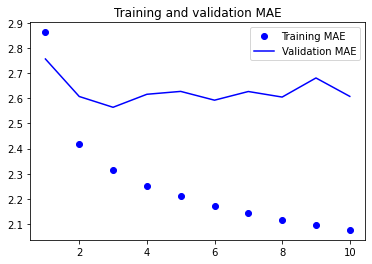

In [14]:
#모델1 결과 그래프

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [15]:
# 상식수준 넘을까? 모델 2: 1d convnet

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 67s 40ms/step - loss: 23.6498 - mae: 3.7800 - val_loss: 17.5484 - val_mae: 3.3612
Epoch 2/10
819/819 [==============================] - 31s 37ms/step - loss: 16.0797 - mae: 3.1838 - val_loss: 14.4867 - val_mae: 3.0168
Epoch 3/10
819/819 [==============================] - 30s 37ms/step - loss: 14.6291 - mae: 3.0311 - val_loss: 14.2166 - val_mae: 2.9746
Epoch 4/10
819/819 [==============================] - 30s 37ms/step - loss: 13.6985 - mae: 2.9309 - val_loss: 14.1026 - val_mae: 2.9598
Epoch 5/10
819/819 [==============================] - 30s 37ms/step - loss: 12.9053 - mae: 2.8439 - val_loss: 14.3837 - val_mae: 2.9967
Epoch 6/10
819/819 [==============================] - 30s 37ms/step - loss: 12.2988 - mae: 2.7769 - val_loss: 15.9725 - val_mae: 3.1819
Epoch 7/10
819/819 [==============================] - 30s 37ms/step - loss: 11.7903 - mae: 2.7151 - val_loss: 14.2545 - val_mae: 2.9723
Epoch 8/10
819/819 [============================

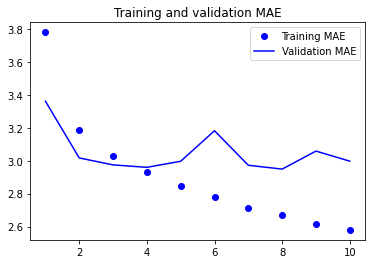

In [16]:
#결과 그래프

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [17]:
#lstm기반 순환 신경망 모델

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 40s 40ms/step - loss: 41.2922 - mae: 4.6856 - val_loss: 12.6839 - val_mae: 2.7213
Epoch 2/10
819/819 [==============================] - 32s 38ms/step - loss: 11.3405 - mae: 2.6152 - val_loss: 9.8067 - val_mae: 2.4441
Epoch 3/10
819/819 [==============================] - 32s 39ms/step - loss: 10.0062 - mae: 2.4663 - val_loss: 10.1088 - val_mae: 2.4855
Epoch 4/10
819/819 [==============================] - 33s 40ms/step - loss: 9.5722 - mae: 2.4089 - val_loss: 9.9179 - val_mae: 2.4618
Epoch 5/10
819/819 [==============================] - 33s 40ms/step - loss: 9.2833 - mae: 2.3689 - val_loss: 9.8114 - val_mae: 2.4507
Epoch 6/10
819/819 [==============================] - 33s 40ms/step - loss: 9.0861 - mae: 2.3396 - val_loss: 10.1543 - val_mae: 2.4977
Epoch 7/10
819/819 [==============================] - 33s 40ms/step - loss: 8.9094 - mae: 2.3143 - val_loss: 9.9347 - val_mae: 2.4609
Epoch 8/10
819/819 [==============================] - 31

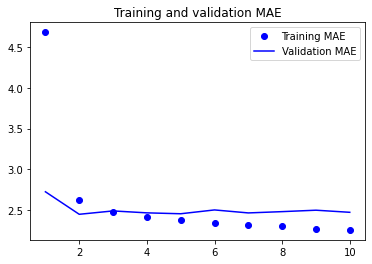

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [23]:
#넘파이로 rnn 정방향 계산 이해해보기

import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)
final_output_sequence.shape

(100, 64)

## 순환신경망 고급 사용법

1. 순환(recurrent) 드롭아웃
2. 스태킹 순환 층
3. 양방향 순환층

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# 순환 드롭아웃
# 원래는 이런식으로 사용, 
# x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)

x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/50
819/819 [==============================] - 33s 39ms/step - loss: 30.1553 - mae: 4.0241 - val_loss: 10.1618 - val_mae: 2.4740
Epoch 2/50
819/819 [==============================] - 32s 39ms/step - loss: 14.8182 - mae: 2.9881 - val_loss: 9.4473 - val_mae: 2.3912
Epoch 3/50
819/819 [==============================] - 32s 39ms/step - loss: 13.6161 - mae: 2.8679 - val_loss: 9.0184 - val_mae: 2.3428
Epoch 4/50
819/819 [==============================] - 32s 39ms/step - loss: 12.8869 - mae: 2.7896 - val_loss: 10.2671 - val_mae: 2.5056
Epoch 5/50
819/819 [==============================] - 32s 39ms/step - loss: 12.4093 - mae: 2.7341 - val_loss: 9.2942 - val_mae: 2.3854
Epoch 6/50
819/819 [==============================] - 32s 39ms/step - loss: 12.0383 - mae: 2.6886 - val_loss: 9.5569 - val_mae: 2.4077
Epoch 7/50
819/819 [==============================] - 32s 39ms/step - loss: 11.7174 - mae: 2.6490 - val_loss: 9.5326 - val_mae: 2.4091
Epoch 8/50
819/819 [==============================] -

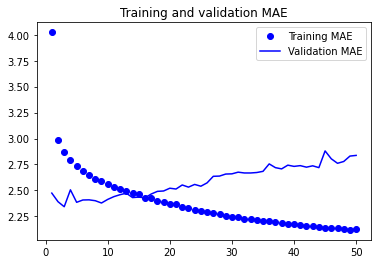

In [27]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [29]:
# 스태킹 순환 층

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외.
# x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
# x = layers.GRU(32, recurrent_dropout=0.5)(x)

# GRU모델 사용
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 36s 41ms/step - loss: 23.0086 - mae: 3.5367 - val_loss: 9.4935 - val_mae: 2.3939
Epoch 2/10
819/819 [==============================] - 33s 40ms/step - loss: 13.4081 - mae: 2.8317 - val_loss: 8.8478 - val_mae: 2.3033
Epoch 3/10
819/819 [==============================] - 33s 40ms/step - loss: 12.4587 - mae: 2.7333 - val_loss: 9.0697 - val_mae: 2.3324
Epoch 4/10
819/819 [==============================] - 33s 40ms/step - loss: 11.7200 - mae: 2.6520 - val_loss: 9.3510 - val_mae: 2.3778
Epoch 5/10
819/819 [==============================] - 32s 39ms/step - loss: 11.0207 - mae: 2.5718 - val_loss: 9.9007 - val_mae: 2.4447
Epoch 6/10
819/819 [==============================] - 33s 40ms/step - loss: 10.3807 - mae: 2.4979 - val_loss: 9.5668 - val_mae: 2.4026
Epoch 7/10
819/819 [==============================] - 33s 40ms/step - loss: 9.7284 - mae: 2.4182 - val_loss: 9.9685 - val_mae: 2.4787
Epoch 8/10
819/819 [==============================] - 33

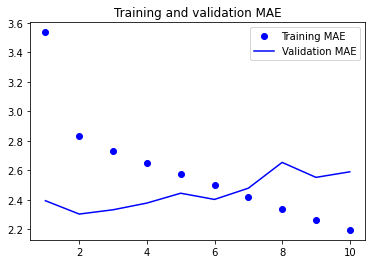

In [30]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show() 

In [31]:
#양방향 RNN을 위해 데이터 순서를 거꾸로 해서 모델에 넣어보자!

def train_generator():
    while True:
        for samples, targets in train_dataset:
            yield samples[:, ::-1, :], targets

def val_generator():
    while True:
        for samples, targets in val_dataset:
            yield samples[:, ::-1, :], targets
        
train_gen = train_generator()
val_gen = val_generator()

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외.
# x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)

x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=819,
                    validation_data=val_gen,
                    validation_steps=410)

Epoch 1/10
819/819 [==============================] - 35s 41ms/step - loss: 34.5435 - mae: 4.5159 - val_loss: 17.8043 - val_mae: 3.3005
Epoch 2/10
819/819 [==============================] - 35s 43ms/step - loss: 22.6412 - mae: 3.7262 - val_loss: 15.9788 - val_mae: 3.1526
Epoch 3/10
819/819 [==============================] - 34s 41ms/step - loss: 19.2211 - mae: 3.4337 - val_loss: 13.4073 - val_mae: 2.8688
Epoch 4/10
819/819 [==============================] - 34s 42ms/step - loss: 16.4002 - mae: 3.1618 - val_loss: 11.3574 - val_mae: 2.6167
Epoch 5/10
819/819 [==============================] - 34s 42ms/step - loss: 15.1076 - mae: 3.0290 - val_loss: 11.0036 - val_mae: 2.5718
Epoch 6/10
819/819 [==============================] - 35s 42ms/step - loss: 14.2329 - mae: 2.9370 - val_loss: 10.3971 - val_mae: 2.5167
Epoch 7/10
819/819 [==============================] - 34s 41ms/step - loss: 13.5674 - mae: 2.8618 - val_loss: 11.3433 - val_mae: 2.6194
Epoch 8/10
819/819 [============================

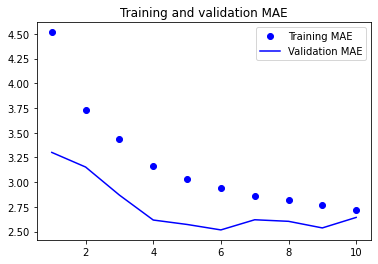

In [32]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
#keras layer모듈을 사용하여 양방향 순환 모델 만들기
# layers.Bidirectional()

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)